# Chapter 3: Calibration of the HBV model

In this chapter the future frequency of threshold exceendance is determined. This is done using different climate change scenarios, which are implemented in the HBV model. To be able to project the future discharge scenarios, the HBV model is used to model the future discharge. The HBV model needs to be calibrated using observation data. The model requires forcings, rainfall and potential evaporation, as inputs. With a set of parameters, which have to be calibrated, it can calculate modelled discharge at the outlet of the catchment. 

The HBV model  is available through eWaterCycle. The developer of the model, Sten Bergström (1992), says the HBV model can best be classified as a semi-distributed conceptual model. The model consists of three main components:
- subroutines for snow accumulation and melt
- subroutines for soil moisture accounting
- response and river routing subroutines

Precipitation and air temperature are the model inputs, and data on potential evapotranspiration is needed for the accounting of soil moisture. (Bergström, 1992)

## General

First of all, some general python and eWaterCycle libraries need to be imported:

In [ ]:
# general python
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import numpy as np
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr

#niceties
from rich import print

#needed
from ipywidgets import IntProgress
from IPython.display import display

# general eWaterCycle
import ewatercycle
import ewatercycle.models
import ewatercycle.forcing

As stated in chapter 3, eWaterCycle provides access to the Caravan dataset, from which a Camel dataset of the catchment of the Wien River is loaded:

In [455]:
camelsgb_id = "lamah_208082"

  The start and end date of the experiment have to be specified. The start and end date of the calibration have to be specified as well. The period of calibration is chosen to be around 75% of the experiment period. This means that the model is trained on 75% of the observation data, and can be tested on 25% of the observation data, to make sure the model is not only working for the data it was trained on, but on other periods of data as well. 

In [516]:
# calibration dates op 75% van de experiment dates zetten!!!

experiment_start_date = "1981-08-01T00:00:00Z"
experiment_end_date = "2020-12-31T00:00:00Z"

calibration_start_time = experiment_start_date
calibration_end_time = "2010-08-31T00:00:00Z"

validation_start_time = "2010-08-31T00:00:00Z"
validation_end_time = experiment_end_date

The forcing data can be generated or previously generated data can be loaded:

In [517]:
# Even though we don't use caravan data as forcing, we still call it forcing
# because it is generated using the forcing module of eWaterCycle
forcing_path_caravan = Path.home() / "forcing" / camelsgb_id / "caravan"
forcing_path_caravan.mkdir(exist_ok=True, parents=True)

# If someone has prepared forcing for you, this path needs to be changed to that location. 
prepared_forcing_path_caravan_central = Path("location/of/forcing/data")

In [518]:
# # option one: generate forcing data
# camelsgb_forcing = ewatercycle.forcing.sources['CaravanForcing'].generate(
#     start_time=experiment_start_date,
#     end_time=experiment_end_date,
#     directory=forcing_path_caravan,
#     basin_id=camelsgb_id,
# )


# option two or three: load data that you or someone else generated previously
camelsgb_forcing = ewatercycle.forcing.sources['CaravanForcing'].load(Path("/home/thirza/forcing/lamah_208082/caravan"))

print(camelsgb_forcing)

CaravanForcing(
    start_time='1981-08-01T00:00:00Z',
    end_time='2030-12-31T00:00:00Z',
    directory=PosixPath('/home/thirza/forcing/lamah_208082/caravan'),
    shape=PosixPath('/home/thirza/forcing/lamah_208082/caravan/lamah_208082.shp'),
    filenames={
        'tasmax': 'lamah_208082_1981-08-01_2030-12-31_tasmax.nc',
        'tas': 'lamah_208082_1981-08-01_2030-12-31_tas.nc',
        'tasmin': 'lamah_208082_1981-08-01_2030-12-31_tasmin.nc',
        'Q': 'lamah_208082_1981-08-01_2030-12-31_Q.nc',
        'pr': 'lamah_208082_1981-08-01_2030-12-31_pr.nc',
        'evspsblpot': 'lamah_208082_1981-08-01_2030-12-31_evspsblpot.nc'
    }
)

Above, it can be seen that the forcing data contains precipitation, potential evaporation, discharge and the near-surface temperatures (tas). For this research, only the discharge data is relevant. The discharge data is loaded from the forcing below.

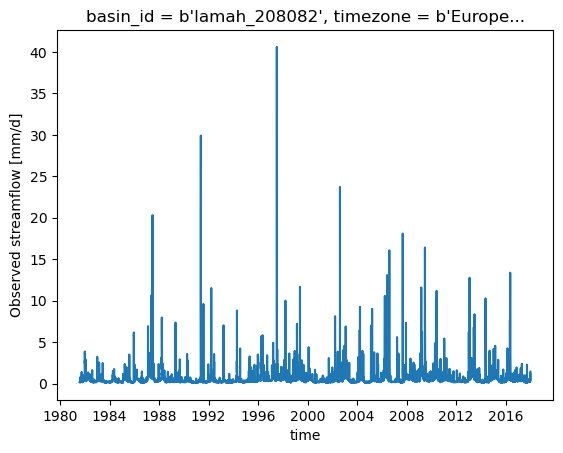

In [486]:
#quick plot of the discharge data.
ds_forcing = xr.open_mfdataset([camelsgb_forcing['Q']])
ds_forcing["Q"].plot()

## Calibration

The HBV model contains five stores where the water is stored and nine parameters that control the flow between those stores and in and out of the model. For the storages an array of starting values is specified. For the nine parameters, initital minimum and maximum values are stated. These values are based on ...

In [482]:

#               Si,  Su, Sf, Ss, Sp
s_0 = np.array([0,  100,  0,  5, 0])
S_names = ["Interception storage", "Unsaturated Rootzone Storage", "Fastflow storage", "Slowflow storage", "Groundwater storage"]

p_names = ["$I_{max}$",  "$C_e$",  "$Su_{max}$", "β",  "$P_{max}$",  "$T_{lag}$",   "$K_f$",   "$K_s$", "FM"]
param_names = ["Imax","Ce",  "Sumax", "beta",  "Pmax",  "Tlag",   "Kf",   "Ks", "FM"]\

# p_min_initial= np.array([0,   0.2,  40,    .5,   .001,   1,     .01,  .0001,  .01])
# p_max_initial = np.array([8,    1,  800,   4,    .3,     10,    .1,   .01,  0.5])

p_min_initial= np.array([0,   0.2,  40,    .5,   .001,   0.1,  .01,  .0001,  .01])
p_max_initial = np.array([8,    4,  800,   4,    3,     10,    3,   .1,  5])


##### The following part tries to find the best parameter combination using a randomizer. Later I used better ways so I commented this part because I don't think I will use it.

### Randomizer

To be able to find a good combination of parameters, a randomizer is used. It creates N possible combinations of parameters, with each of these parameters having a value in between the initial minimum and maximum values.

In [208]:
N = 1000

parameters = np.random.uniform(p_min_initial[:, np.newaxis], p_max_initial[:, np.newaxis], (len(p_min_initial), N))
# print(parameters)

The next step is to run the HBV model with the forcing, the randomly chosen parameters and the initally set storage data. First of all an empty list is made, called 'ensemble'. The HBV model is run N times, with every time another set of the randomly chosen parameters from above. The outcomes of the HBV model are stored in the ensemble list.

In [209]:
ensemble = []

for counter in range(N): 
    ensemble.append(ewatercycle.models.HBVLocal(forcing=camelsgb_forcing))
    config_file, _ = ensemble[counter].setup(
                            parameters = parameters[:,counter],
                            initial_storage=s_0,
                            cfg_dir = "configFiles/hbv_ensembleMember_" + str(counter),
                               )
    ensemble[counter].initialize(config_file)

To be able to determine if the outcomes of the HBV model are any good, the results can be compared to the observations. It is important to first determine when the model works good. This research focusses on the flooding threshold of the U4 subway line. Flooding happens at high discharges, peaks. This implies that the model can be seen as good, when the amount and height of the modelles peaks are similar to the peaks in the observed data. This is done with the following function. The difference between the modelled data and the observed data is raised to the second power, to 'punish' large absolute differences more heavy. The absolute difference between the observed data and the modelled data is higher at the peaks. In this way the parameter combination is looked for which results in the 'best' model, defined above. 

In [210]:
def calibrationObjective(modelOutput, observation, start_calibration, end_calibration):
    # a function that takes in two dataFrames, interpolates the model output to the
    # observations and calculates the average absolute difference between the two.

    #combine the two in one dataFrame
    hydro_data = pd.concat([modelOutput.reindex(observation.index, method = 'ffill'), observation], axis=1)

    #only select the calibration period
    hydro_data = hydro_data[hydro_data.index > pd.to_datetime(pd.Timestamp(start_calibration).date())]
    hydro_data = hydro_data[hydro_data.index < pd.to_datetime(pd.Timestamp(end_calibration).date())]

    #calculate mean absolute difference to the power 4, so peaks weigh more
    diff = (hydro_data['Q'] - hydro_data['model output']) ** 2
    absDiff = np.abs(diff)
    meanAbsDiff = np.mean(absDiff)

    return meanAbsDiff

Now the differences between the model and the observed data can actually be calculated. Every ensemble is compared to the observed data. The mean absolute differences between the modelled discharges and the observed discharges are called objectives. 

In [211]:
#an object to show a progress bar, since this can take a while:
f = IntProgress(min=0, max=N) # instantiate the bar
display(f) # display the bar

#converting the observations to a pandas object
Q_pandas = ds_forcing["Q"].to_dataframe()
#an empty array to store the results in
objectives = []

#loop over all ensemble members
for ensembleMember in ensemble:
    Q_m = []
    time = []
    while ensembleMember.time < ensembleMember.end_time:
        ensembleMember.update()
        discharge_this_timestep = ensembleMember.get_value("Q")
        Q_m.append(discharge_this_timestep[0])
        time.append(pd.Timestamp(ensembleMember.time_as_datetime.date()))

    #calculate the objective function 
    discharge_dataframe = pd.DataFrame({'model output': Q_m}, index=pd.to_datetime(time))
    objective_this_model = calibrationObjective(discharge_dataframe,Q_pandas["Q"],calibration_start_time,calibration_end_time)
    objectives.append(objective_this_model)

    #it is good practice to remove any variable you don't need anymore to save memory.
    del Q_m, time, discharge_dataframe, objective_this_model
   
    #update progress bar
    f.value += 1

# print(objectives)  

IntProgress(value=0, max=1000)

In [212]:
#let's also show the minimal values:
parameters_minimum_index = np.argmin(np.array(objectives))

objective_minimum = np.min(objectives)

parameters_minimum = parameters[:,parameters_minimum_index]

print("Best parameter index:", parameters_minimum_index)
print("Best parameter set:", parameters_minimum)
print("Objective: ", objective_minimum)


Best parameter index: 403

Best parameter set: [1.30531138e-01 8.53231694e-01 1.56436715e+02 1.35969715e+00
 1.50986571e-02 1.04371241e+00 3.89692752e-01 6.22991134e-02
 8.83438042e-01]

Objective:  0.8989231889998252

In [15]:
#finaly, just like before, we remove the models themselves to save up space and memory.
for ensembleMember in ensemble:
    ensembleMember.finalize()

Now the results can be analyzed. The parameter set that results in the lowest objective value, is the best found parameter combination to calibrate the model to the observations.  

In [213]:
import matplotlib.pyplot as plt

In [ ]:
# xFigNr = 2
# yFigNr = 4

# fig, axs = plt.subplots(xFigNr, yFigNr,figsize = (15,15))

# for xFig in range(xFigNr):
#     for yFig in range(yFigNr):
#         paramCounter = xFig*yFigNr + yFig
#         axs[xFig,yFig].plot(parameters[paramCounter,:],objectives,'.')
#         axs[xFig,yFig].set_title(p_names[paramCounter])

We can compare the modelled discharge to the observed discharge by plotting both. First a model object needs to be created. Following, a configuration file is created that cotains information on the location of the forcing files and the values of the inital storages and the parameters. Then the model gets primed to start running through initializing.

In [215]:
par_0 = parameters_minimum
model = ewatercycle.models.HBVLocal(forcing=camelsgb_forcing)
config_file, _ = model.setup(parameters=par_0, initial_storage=s_0)
model.initialize(config_file)

Now the model can start running.

In [216]:
Q_m = []
time = []
while model.time < model.end_time:
    model.update()
    Q_m.append(model.get_value("Q")[0])
    time.append(pd.Timestamp(model.time_as_datetime))
model.finalize()

In [217]:
model_output = pd.Series(data=Q_m, name="Modelled_discharge", index=time)

The modelled discharge and the observed discharge can be plotted to determine the accuracy of the model.

Text(0, 0.5, 'Discharge (mm/d)')

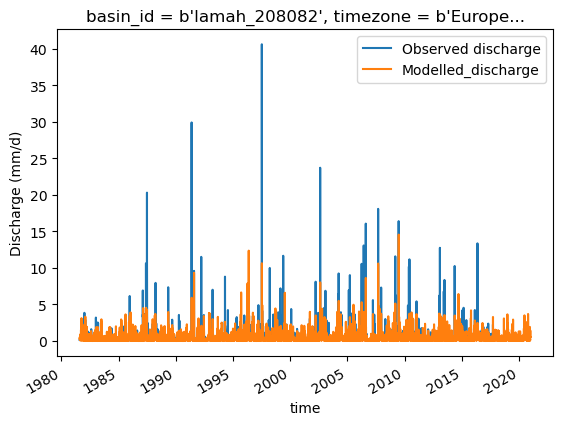

In [218]:
ds_forcing["Q"].plot(label="Observed discharge")
model_output.plot()
plt.legend()
plt.ylabel("Discharge (mm/d)")

To be able to use the output of the model in other analyses, it is saved as a NetCDF file:

In [219]:
xr_model_output = model_output.to_xarray()

xr_model_output.attrs['units'] = 'mm/d'

# Save the xarray Dataset to a NetCDF file
xr_model_output.to_netcdf('~/river_discharge_data.nc')

### Quantile Loss method and optimization with Nelder-Mead

Another way of weighing the peaks more heavily is using the quantile loss method. The quantile loss method measures how well the model predicts a specific quantile by penalizing over- and under predictions more heavily. A quantile of more than 50 percent, weighs under predictions more heavily, and thus focusses more on the peaks.

Before, the parameter combinations were chosen randomly. A better way to predict the best parameter combination is through Nelder-Mead optimization. This optimization method finds the minimum of a function. The result of the Nelder-Mead optimization is the best parameter combination the method found. The Nelder-Mead optimization is run using the quantile loss method with quantiles of 90, 95 and 99 percent. All three the quantiles were used for now to see how they would result. 

In [519]:
def calibrationObjective_quantile_loss(modelOutput, observation, start_calibration, end_calibration, q):
    # a function that takes in two dataFrames, interpolates the model output to the
    # observations and calculates the average absolute difference between the two.

    #combine the two in one dataFrame
    hydro_data = pd.concat([modelOutput.reindex(observation.index, method = 'ffill'), observation], axis=1)

    #only select the calibration period
    hydro_data = hydro_data[hydro_data.index > pd.to_datetime(pd.Timestamp(start_calibration).date())]
    hydro_data = hydro_data[hydro_data.index < pd.to_datetime(pd.Timestamp(end_calibration).date())]

    #calculate mean absolute difference to the power 4, so peaks weigh more
    diff = (hydro_data['Q'] - hydro_data['model output']) 
    absDiff = np.abs(diff)
    meanAbsDiff = np.mean(absDiff)
    
    return np.mean(np.maximum(q * diff, (q - 1) * diff))  # Quantile loss formule
    

    #return meanAbsDiff

In [520]:
ensemble.append(ewatercycle.models.HBVLocal(forcing=camelsgb_forcing))
config_file, _ = ensemble[counter].setup(
                            parameters = parameters[:,counter],
                            initial_storage=s_0,
                            cfg_dir = "configFiles/hbv_ensembleMember_" + str(counter),
                               )
ensemble[counter].initialize(config_file)

In [521]:
def objective_function(parameter_vector, q):
    model = ewatercycle.models.HBVLocal(forcing=camelsgb_forcing)
    config_file, _ = model.setup(            parameters = parameter_vector,
                            initial_storage=s_0,
                            cfg_dir = "configFiles/hbv_ensembleMember_",
                               )
    model.initialize(config_file)


   # discharge_this_timestep = model.get_value("Q") 
    Q_m = []
    time = []
    while model.time < model.end_time:
        model.update()
        discharge_this_timestep = model.get_value("Q")
        Q_m.append(discharge_this_timestep[0])
        time.append(pd.Timestamp(model.time_as_datetime.date()))
   # model.finalize()
   # print(model.get_value("Q"))

    #calculate the objective function 
    discharge_dataframe = pd.DataFrame({'model output': Q_m}, index=pd.to_datetime(time))

    objective_this_model = calibrationObjective_quantile_loss(discharge_dataframe,Q_pandas["Q"],calibration_start_time,calibration_end_time, q)
    del Q_m, time, discharge_dataframe
   
    if np.isnan(objective_this_model):
        return np.inf
    
    return objective_this_model

In [522]:
# objective_function(parameters_minimum)

In [523]:
p_min_initial= np.array([0,   0.2,  40,    .5,   .001,   1,     .01,  .0001,  .01])
p_max_initial = np.array([50,    1,  800,   40,    3,     10,    1,   .1,  0.9])

The next cell is commented because the cell takes very long to run, so I did not want to run it accidentally. I hardcoded the outcomes of the cell in the cells below.

In [524]:
# from scipy.optimize import minimize


# #bounds = [(0, 500), (0.2, 10),(40, 10000),(0.5, 10000),(0.001, 300),(1, 100),(0.01, 100),(0.0001, 10),(0.01, 100)]
# bounds = [(0, None), (0.001, None),(0.001, None),(0.001, None),(0.001, None),(0.001, None),(0.001, None),(0.001, None),(0.001, None)]

# # result = minimize(objective_function, [2.10831791e+01, 2.85049614e-01, 2.05644822e+03, 2.62675362e+01,
# #  2.90142667e+02, 1.37651503e+00, 2.39202301e+00, 1.26140676e+00,
# #  2.99032767e-01], bounds=bounds, method='Nelder-Mead', options={'xatol' : 0.000001})

# result90 = minimize(objective_function, [2.52268517e-05, 2.20175052e+00, 1.45074493e+02, 2.48038674e+00,
#        1.01841470e+00, 6.84361550e-01, 5.85949449e-01, 4.42305303e-02,
#        1.05644244e+00], bounds=bounds, method='Nelder-Mead', options={'maxiter':3000}, args=(0.9,))

# result95 = minimize(objective_function, [2.52268517e-05, 2.20175052e+00, 1.45074493e+02, 2.48038674e+00,
#        1.01841470e+00, 6.84361550e-01, 5.85949449e-01, 4.42305303e-02,
#        1.05644244e+00], bounds=bounds, method='Nelder-Mead', options={'maxiter':3000}, args=(0.95,))


# result99 = minimize(objective_function, [2.52268517e-05, 2.20175052e+00, 1.45074493e+02, 2.48038674e+00,
#        1.01841470e+00, 6.84361550e-01, 5.85949449e-01, 4.42305303e-02,
#        1.05644244e+00], bounds=bounds, method='Nelder-Mead', options={'maxiter':3000}, args=(0.99,))

In [525]:
result90

[5.58471586e-06,
 3.13412625,
 237.953048,
 5.73162134,
 0.652902354,
 1.45007782,
 0.504868854,
 0.0409678016,
 1.0886803]

In [526]:
result95

[1.11445722e-08,
 2.44479717,
 42.537041,
 1.2268688,
 2.09277774,
 1.04205225,
 0.727472601,
 0.0349031666,
 1.08389293]

In [527]:
result99

[1.04288193e-05,
 77.7284772,
 23.2176569,
 0.660999969,
 3.51075714,
 0.961766614,
 0.811764125,
 0.0370046705,
 1.00978819]

In [528]:
# print(result90.fun)
objective90 = 0.11857370061371166
# print(result95.fun)
objective95 = 0.08865588020728175
# print(result99.fun)
objective99 = 0.04227177059570846
# 0.9847863938751269  L-BFGS-B   kwadraat
#    0.78874967095675                 Nelder-Mead  kwadraat

#1.4835419784065083  random met **4

In [529]:
# result90.x 
# print(result90.x)
result90 = [5.58471586e-06, 3.13412625e+00, 2.37953048e+02, 5.73162134e+00,
 6.52902354e-01, 1.45007782e+00, 5.04868854e-01, 4.09678016e-02,
 1.08868030e+00]

# result95.x
# print(result95.x)
result95 = [1.11445722e-08, 2.44479717e+00, 4.25370410e+01, 1.22686880e+00,
 2.09277774e+00, 1.04205225e+00, 7.27472601e-01, 3.49031666e-02,
 1.08389293e+00]

# result99.x
# print(result99.x)
result99 = [1.04288193e-05, 7.77284772e+01, 2.32176569e+01, 6.60999969e-01,
 3.51075714e+00, 9.61766614e-01, 8.11764125e-01, 3.70046705e-02,
 1.00978819e+00]

In [530]:
par_90 = result90
model = ewatercycle.models.HBVLocal(forcing=camelsgb_forcing)
config_file, _ = model.setup(parameters=par_90, initial_storage=s_0)
model.initialize(config_file)

In [531]:
Q_m = []
time = []
while model.time < model.end_time:
    model.update()
    Q_m.append(model.get_value("Q")[0])
    time.append(pd.Timestamp(model.time_as_datetime))
model.finalize()

In [532]:
model_output90 = pd.Series(data=Q_m, name="Modelled_discharge", index=time)

Text(0.5, 1.0, 'Modelled and Observed discharge with q=0.90')

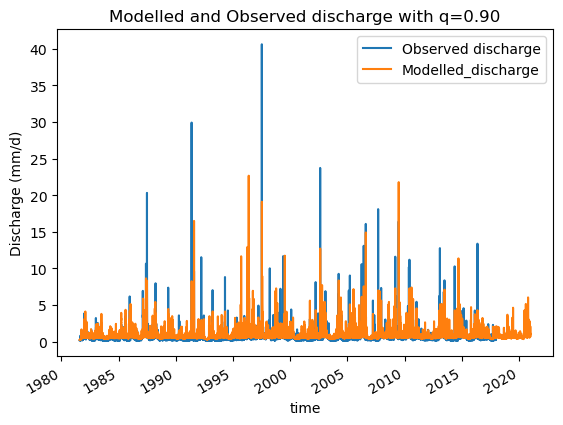

In [543]:
ds_forcing["Q"].plot(label="Observed discharge")
model_output90.plot()
plt.legend()
plt.ylabel("Discharge (mm/d)")
plt.title('Modelled and Observed discharge with q=0.90')

In [534]:
par_95 = result95
model = ewatercycle.models.HBVLocal(forcing=camelsgb_forcing)
config_file, _ = model.setup(parameters=par_95, initial_storage=s_0)
model.initialize(config_file)

In [535]:
Q_m = []
time = []
while model.time < model.end_time:
    model.update()
    Q_m.append(model.get_value("Q")[0])
    time.append(pd.Timestamp(model.time_as_datetime))
model.finalize()

In [536]:
model_output95 = pd.Series(data=Q_m, name="Modelled_discharge", index=time)

Text(0.5, 1.0, 'Modelled and Observed discharge with q=0.95')

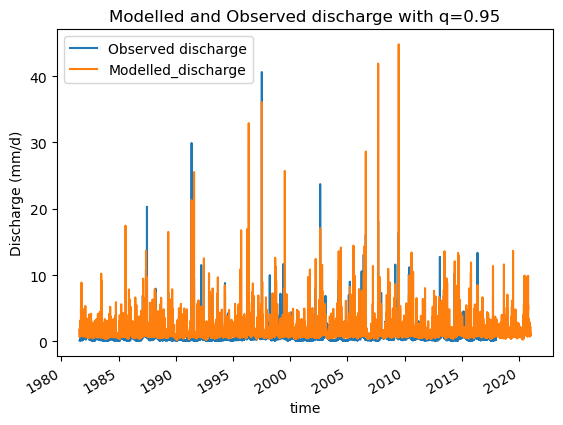

In [544]:
ds_forcing["Q"].plot(label="Observed discharge")
model_output95.plot()
plt.legend()
plt.ylabel("Discharge (mm/d)")
plt.title('Modelled and Observed discharge with q=0.95')

In [538]:
par_99 = result99
model = ewatercycle.models.HBVLocal(forcing=camelsgb_forcing)
config_file, _ = model.setup(parameters=par_99, initial_storage=s_0)
model.initialize(config_file)

In [539]:
Q_m = []
time = []
while model.time < model.end_time:
    model.update()
    Q_m.append(model.get_value("Q")[0])
    time.append(pd.Timestamp(model.time_as_datetime))
model.finalize()

In [540]:
model_output99 = pd.Series(data=Q_m, name="Modelled_discharge", index=time)

Text(0.5, 1.0, 'Modelled and Observed discharge with q=0.99')

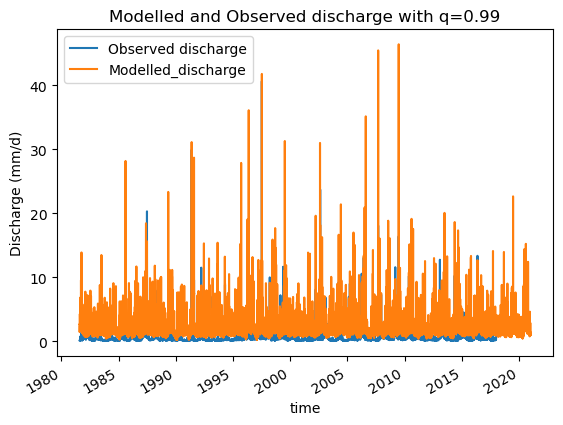

In [545]:
ds_forcing["Q"].plot(label="Observed discharge")
model_output99.plot()
plt.legend()
plt.ylabel("Discharge (mm/d)")
plt.title('Modelled and Observed discharge with q=0.99')

The next step is to validate the model output. This is done on the validation time period, which is the last 25 percent, so the last ten years, of the observed data. The mean absolute difference of the model output and the observed data, named the objective, of the calibration period can be compared to the objective of the validation period. The model is not overfitted for the calibration period, and thus usable for future predictions, if the objective values are similar. 

In [510]:
def objective_function_validation(parameter_vector, q):
    model = ewatercycle.models.HBVLocal(forcing=camelsgb_forcing)
    config_file, _ = model.setup(            parameters = parameter_vector,
                            initial_storage=s_0,
                            cfg_dir = "configFiles/hbv_ensembleMember_",
                               )
    model.initialize(config_file)


   # discharge_this_timestep = model.get_value("Q") 
    Q_m = []
    time = []
    while model.time < model.end_time:
        model.update()
        discharge_this_timestep = model.get_value("Q")
        Q_m.append(discharge_this_timestep[0])
        time.append(pd.Timestamp(model.time_as_datetime.date()))
   # model.finalize()
   # print(model.get_value("Q"))

    #calculate the objective function 
    discharge_dataframe = pd.DataFrame({'model output': Q_m}, index=pd.to_datetime(time))

    objective_this_model = calibrationObjective_quantile_loss(discharge_dataframe,Q_pandas["Q"],validation_start_time,validation_end_time, q)
    del Q_m, time, discharge_dataframe
   
    if np.isnan(objective_this_model):
        return np.inf
    
    return objective_this_model

In [546]:
val90_objective = objective_function_validation([5.58471586e-06, 3.13412625e+00, 2.37953048e+02, 5.73162134e+00,
 6.52902354e-01, 1.45007782e+00, 5.04868854e-01, 4.09678016e-02,
 1.08868030e+00], 0.90)
print(objective90)
print(val90_objective)

0.11857370061371166

0.09339490016948018

In [547]:
val95_objective = objective_function_validation([1.11445722e-08, 2.44479717e+00, 4.25370410e+01, 1.22686880e+00,
 2.09277774e+00, 1.04205225e+00, 7.27472601e-01, 3.49031666e-02,
 1.08389293e+00], 0.95)
print(objective90)
print(val95_objective)

0.11857370061371166

0.07222547672725184

In [548]:
val99_objective = objective_function_validation([1.04288193e-05, 7.77284772e+01, 2.32176569e+01, 6.60999969e-01,
 3.51075714e+00, 9.61766614e-01, 8.11764125e-01, 3.70046705e-02,
 1.00978819e+00], 0.99)
print(objective99)
print(val99_objective)

0.04227177059570846

0.0339318687843097

It can be seen that for all three models, the objective for the validation period is lower than the objective for the training period. This would mean that the model is not overfit on the trainingsdata, since it is able to make good predictions on unseen data. The fact that the objective is lower for the testdata could mean that the testdata contains data that is easier to predict. It can be seen in the graphs above, that the observed data in the test period, so from 2010 to 2021, does not contain peaks as high as in the training period, from 1980 to 2010. The model might be improved by using cross validation.

### Kling Gupta efficiency

For my research, the height and frequency of the peaks are important, but their timing is less critical. The Kling-Gupta Efficiency is a measure that evaluates how well a model performs by looking at correlation, bias, and variability. It is especially useful for predicting the size of peaks and the overall distribution, while being less focused on the exact timing of the peaks.

In [603]:
import numpy as np

def kling_gupta_efficiency(obs, sim, start_calibration, end_calibration):

    #combine the two in one dataFrame
    hydro_data = pd.concat([sim.reindex(obs.index, method = 'ffill'), obs], axis=1)

    #only select the calibration period
    hydro_data = hydro_data[hydro_data.index > pd.to_datetime(pd.Timestamp(start_calibration).date())]
    hydro_data = hydro_data[hydro_data.index < pd.to_datetime(pd.Timestamp(end_calibration).date())]


    #  #calculate mean absolute difference to the power 4, so peaks weigh more
    # diff = (hydro_data['Q'] - hydro_data['model output']) 
    # absDiff = np.abs(diff)
    # meanAbsDiff = np.mean(absDiff)
    
    r = np.corrcoef(hydro_data['Q'], hydro_data['model output'])[0, 1]  # Correlation
    beta = np.mean(hydro_data['model output']) / np.mean(hydro_data['Q'])  # Bias ratio
    gamma = np.std(hydro_data['model output']) / np.std(hydro_data['Q'])  # Variability ratio
    
    return -(1 - np.sqrt((r - 1) ** 2 + (beta - 1) ** 2 + (gamma - 1) ** 2))

# objective = kling_gupta_efficiency(observations, model_output)


In [604]:
def objective_function(parameter_vector):
    model = ewatercycle.models.HBVLocal(forcing=camelsgb_forcing)
    config_file, _ = model.setup(            parameters = parameter_vector,
                            initial_storage=s_0,
                            cfg_dir = "configFiles/hbv_ensembleMember_",
                               )
    model.initialize(config_file)


   # discharge_this_timestep = model.get_value("Q") 
    Q_m = []
    time = []
    while model.time < model.end_time:
        model.update()
        discharge_this_timestep = model.get_value("Q")
        Q_m.append(discharge_this_timestep[0])
        time.append(pd.Timestamp(model.time_as_datetime.date()))
   # model.finalize()
   # print(model.get_value("Q"))

    #calculate the objective function 
    discharge_dataframe = pd.DataFrame({'model output': Q_m}, index=pd.to_datetime(time))

    objective_this_model = kling_gupta_efficiency(discharge_dataframe, Q_pandas["Q"], calibration_start_time, calibration_end_time)
    del Q_m, time, discharge_dataframe
   
    if np.isnan(objective_this_model):
        return np.inf
    
    return objective_this_model

In [613]:
from scipy.optimize import minimize


#bounds = [(0, 500), (0.2, 10),(40, 10000),(0.5, 10000),(0.001, 300),(1, 100),(0.01, 100),(0.0001, 10),(0.01, 100)]
bounds = [(0, None), (0.001, None),(0.001, None),(0.001, None),(0.001, None),(0.001, None),(0.001, None),(0.001, None),(0.001, None)]

result90 = minimize(objective_function, [2.52268517e-05, 2.20175052e+00, 1.45074493e+02, 2.48038674e+00,
       1.01841470e+00, 6.84361550e-01, 5.85949449e-01, 4.42305303e-02,
       1.05644244e+00], bounds=bounds, method='Nelder-Mead', options={'maxiter':100})

In [614]:
result90

       message: Maximum number of iterations has been exceeded.
       success: False
        status: 2
           fun: -0.5036647074766698
             x: [ 3.257e-05  1.556e+00  1.405e+02  3.016e+00  2.671e-01
                  6.978e-01  8.097e-01  3.995e-02  1.141e+00]
           nit: 100
          nfev: 144
 final_simplex: (array([[ 3.257e-05,  1.556e+00, ...,  3.995e-02,
                         1.141e+00],
                       [ 3.200e-05,  1.528e+00, ...,  4.211e-02,
                         1.016e+00],
                       ...,
                       [ 3.168e-05,  1.594e+00, ...,  4.188e-02,
                         1.015e+00],
                       [ 3.177e-05,  1.529e+00, ...,  4.242e-02,
                         1.013e+00]]), array([-5.037e-01, -5.014e-01, -5.007e-01, -5.006e-01,
                       -4.994e-01, -4.993e-01, -4.993e-01, -4.983e-01,
                       -4.982e-01, -4.979e-01]))

In [615]:
result90.x

array([3.25683830e-05, 1.55625787e+00, 1.40454772e+02, 3.01564724e+00,
       2.67053370e-01, 6.97751529e-01, 8.09680964e-01, 3.99505296e-02,
       1.14067403e+00])

In [616]:
result90.fun

-0.5036647074766698

In [617]:
par_99 = result90.x
model = ewatercycle.models.HBVLocal(forcing=camelsgb_forcing)
config_file, _ = model.setup(parameters=par_99, initial_storage=s_0)
model.initialize(config_file)

In [618]:
Q_m = []
time = []
while model.time < model.end_time:
    model.update()
    Q_m.append(model.get_value("Q")[0])
    time.append(pd.Timestamp(model.time_as_datetime))
model.finalize()

In [619]:
model_output99 = pd.Series(data=Q_m, name="Modelled_discharge", index=time)

Text(0, 0.5, 'Discharge (mm/d)')

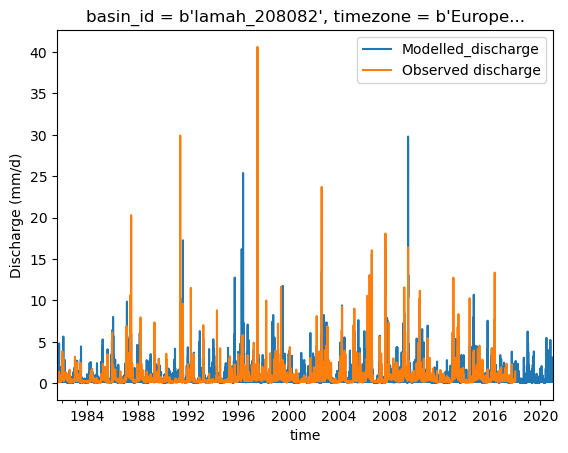

In [620]:
model_output99.plot()
ds_forcing["Q"].plot(label="Observed discharge")

plt.legend()
plt.ylabel("Discharge (mm/d)")

to consider:
- cross validation
-  which one to use eventually